In [1]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("TensorFlow Version:", tf.__version__)

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow Version: 2.19.0


In [2]:
# For Training (Most packages pre-installed):
!pip install -q tensorflow==2.15.0
!pip install -q mediapipe
!pip install -q opencv-python
!pip install -q opencv-python
!pip install -q mediapipe
print("\n✅ All dependencies installed!")

ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.2.6 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of t

In [3]:
# CELL 2: Import All Dependencies
# ============================================================
from tensorflow.keras import layers, models, mixed_precision
from tensorflow.keras.applications import EfficientNetB3
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from collections import Counter

print("✅ All imports successful!")

✅ All imports successful!


In [4]:

# CELL 5: Mount Google Drive & Verify Dataset
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = '/content/drive/MyDrive/asl_dataset'

# Verify dataset exists
if os.path.exists(DATA_DIR):
    classes = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
    print(f"✅ Dataset found! {len(classes)} classes detected")
    print(f"Classes: {classes[:10]}..." if len(classes) > 10 else f"Classes: {classes}")

    # Count total images
    total_images = sum([len(files) for r, d, files in os.walk(DATA_DIR)
                       if any(f.lower().endswith(('.png', '.jpg', '.jpeg')) for f in files)])
    print(f"Total images: {total_images:,}")
else:
    print("❌ Dataset not found! Please upload to Google Drive first.")
    print(f"Expected path: {DATA_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset found! 36 classes detected
Classes: ['u', 'z', 'y', 'x', 'v', 't', 'r', 'w', 'q', 's']...
Total images: 2,515


In [5]:
# CELL 7: Setup Model Save Paths
# ============================================================
MODEL_SAVE_DIR = '/content/drive/MyDrive/sign_language_models'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

CHECKPOINT_PATH = os.path.join(MODEL_SAVE_DIR, 'best_model_checkpoint.keras')
FINAL_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'sign_language_final.keras')
TFLITE_PATH = os.path.join(MODEL_SAVE_DIR, 'sign_language.tflite')

print(f"💾 Models will be saved to: {MODEL_SAVE_DIR}")

💾 Models will be saved to: /content/drive/MyDrive/sign_language_models


In [6]:

# ============================================================
# Image and batch settings
IMG_SIZE = (300, 300)
BATCH_SIZE = 16  # Optimized for Colab T4
VAL_SPLIT = 0.2
SEED = 1337

# Model settings
NUM_CLASSES = 36  # A-Z (26) + 0-9 (10)
UNFREEZE_LAYERS = 80

# Training settings
WARMUP_LR = 1e-3
FINETUNE_LR = 5e-5
EPOCHS_WARMUP = 15
EPOCHS_FINETUNE = 30

print(f"""
⚙️ Training Configuration:
   📐 Image Size: {IMG_SIZE}
   📦 Batch Size: {BATCH_SIZE}
   🎯 Classes: {NUM_CLASSES}
   📚 Total Epochs: {EPOCHS_WARMUP + EPOCHS_FINETUNE}
   ⏱️ Estimated Time: 2-3 hours on T4 GPU
""")


⚙️ Training Configuration:
   📐 Image Size: (300, 300)
   📦 Batch Size: 16
   🎯 Classes: 36
   📚 Total Epochs: 45
   ⏱️ Estimated Time: 2-3 hours on T4 GPU



In [7]:
def create_datasets(data_dir, img_size, batch_size, val_split, seed):
    """Create train and validation datasets"""

    # Create train split
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=val_split,
        subset="training",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="categorical"
    )

    # Create validation split
    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=val_split,
        subset="validation",
        seed=seed,
        image_size=img_size,
        batch_size=batch_size,
        label_mode="categorical"
    )

    return train_ds, val_ds, train_ds.class_names

# Load datasets
train_ds, val_ds, class_names = create_datasets(
    DATA_DIR, IMG_SIZE, BATCH_SIZE, VAL_SPLIT, SEED
)

print(f"📊 Dataset Info:")
print(f"   Classes: {len(class_names)}")
print(f"   Class names: {class_names}")

# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

print("✅ Datasets loaded and optimized!")

Found 2515 files belonging to 36 classes.
Using 2012 files for training.
Found 2515 files belonging to 36 classes.
Using 503 files for validation.
📊 Dataset Info:
   Classes: 36
   Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
✅ Datasets loaded and optimized!


In [8]:

# CELL 9: Data Augmentation Pipeline
# ============================================================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2, 0.2),
    layers.RandomTranslation(0.15, 0.15),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
    # Cutout augmentation
    layers.RandomCrop(height=int(IMG_SIZE[0]*0.9), width=int(IMG_SIZE[1]*0.9)),
    layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
], name="augmentation")

preprocess_input = tf.keras.applications.efficientnet.preprocess_input

print("✅ Augmentation pipeline created!")

✅ Augmentation pipeline created!


In [9]:
# Base model

base_model = EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False

# def create_model(base_model, num_classes, img_size):
#     """Create model with attention mechanism"""

#     inputs = layers.Input(shape=img_size + (3,), name="input")

#     # Augmentation and preprocessing
#     x = data_augmentation(inputs)
#     x = preprocess_input(x)

#     # Base model features
#     x = base_model(x, training=False)

#     # Spatial attention
#     attention = layers.Conv2D(1, (1, 1), activation='sigmoid', name='attention')(x)
#     x = layers.Multiply()([x, attention])

#     # Global pooling (both average and max)
#     gap = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
#     gmp = layers.GlobalMaxPooling2D(name="global_max_pool")(x)
#     x = layers.Concatenate()([gap, gmp])

#     # Dense head
#     x = layers.Dense(512, activation=None)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.Dropout(0.5)(x)

#     x = layers.Dense(256, activation=None)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.Dropout(0.4)(x)

#     # Output
#     outputs = layers.Dense(num_classes, activation="softmax", name="output")(x)

#     return models.Model(inputs, outputs, name="sign_language_efficientnet")
def create_model(base_model, num_classes, img_size):
    """Create model with attention mechanism"""

    inputs = layers.Input(shape=img_size + (3,), name="input")

    # Augmentation and preprocessing
    x = data_augmentation(inputs)
    x = preprocess_input(x)

    # Base model features
    x = base_model(x, training=False)

    # Spatial attention
    attention = layers.Conv2D(1, (1, 1), activation='sigmoid', name='attention')(x)
    x = layers.Multiply()([x, attention])

    # Global pooling
    gap = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
    gmp = layers.GlobalMaxPooling2D(name="global_max_pool")(x)
    x = layers.Concatenate()([gap, gmp])

    # Dense head with MORE dropout if needed
    x = layers.Dense(512, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)  # Already sufficient

    x = layers.Dense(256, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)  # Already sufficient

    outputs = layers.Dense(num_classes, activation="softmax", name="output")(x)

    return models.Model(inputs, outputs, name="sign_language_efficientnet")

model = create_model(base_model, NUM_CLASSES, IMG_SIZE)

print(f"\n🏗️ Model created:")
print(f"   Total params: {model.count_params():,}")
print(f"   Trainable params: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")



🏗️ Model created:
   Total params: 12,502,100
   Trainable params: 1,717,029


In [10]:
class DetailedMetrics(tf.keras.callbacks.Callback):
    """Custom callback for detailed metrics"""
    def on_epoch_end(self, epoch, logs=None):
        print(f"   📈 Epoch {epoch+1}: "
              f"train_acc={logs['accuracy']:.4f}, val_acc={logs['val_accuracy']:.4f}, "
              f"train_loss={logs['loss']:.4f}, val_loss={logs['val_loss']:.4f}")

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=12,
        min_delta=0.0001,
        mode="max",
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        CHECKPOINT_PATH,
        monitor="val_accuracy",
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    DetailedMetrics(),
]

print("✅ Callbacks configured!")

✅ Callbacks configured!


In [11]:

# CELL 12: Phase 1 - Warmup Training
# ============================================================
print("\n" + "="*60)
print("🔹 PHASE 1: Warmup Training (Frozen Base)")
print("="*60)

start_time = time.time()

model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=WARMUP_LR,
        weight_decay=0.0001
    ),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        "accuracy",
        tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_acc'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_acc')
    ]
)

history_warmup = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_WARMUP,
    callbacks=callbacks,
    verbose=2
)

warmup_time = time.time() - start_time
print(f"\n✅ Phase 1 complete! Time: {warmup_time/60:.1f} minutes")



🔹 PHASE 1: Warmup Training (Frozen Base)
Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.10338, saving model to /content/drive/MyDrive/sign_language_models/best_model_checkpoint.keras
   📈 Epoch 1: train_acc=0.0800, val_acc=0.1034, train_loss=3.6942, val_loss=4.3229
126/126 - 259s - 2s/step - accuracy: 0.0800 - loss: 3.6942 - top_3_acc: 0.2028 - top_5_acc: 0.2927 - val_accuracy: 0.1034 - val_loss: 4.3229 - val_top_3_acc: 0.2505 - val_top_5_acc: 0.3797 - learning_rate: 0.0010
Epoch 2/15

Epoch 2: val_accuracy improved from 0.10338 to 0.27833, saving model to /content/drive/MyDrive/sign_language_models/best_model_checkpoint.keras
   📈 Epoch 2: train_acc=0.1909, val_acc=0.2783, train_loss=3.0719, val_loss=2.6074
126/126 - 21s - 168ms/step - accuracy: 0.1909 - loss: 3.0719 - top_3_acc: 0.4026 - top_5_acc: 0.5358 - val_accuracy: 0.2783 - val_loss: 2.6074 - val_top_3_acc: 0.5567 - val_top_5_acc: 0.6839 - learning_rate: 0.0010
Epoch 3/15

Epoch 3: val_accuracy improved from 0.27833

In [12]:
# CELL 13: Phase 2 - Fine-tuning
# ============================================================
print("\n" + "="*60)
print("🔹 PHASE 2: Fine-tuning (Unfrozen Layers)")
print("="*60)

# Unfreeze last layers
base_model.trainable = True
frozen_count = 0

for layer in base_model.layers[:-UNFREEZE_LAYERS]:
    layer.trainable = False
    frozen_count += 1

# Keep BatchNorm frozen
for layer in base_model.layers[-UNFREEZE_LAYERS:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

print(f"   Frozen layers: {frozen_count}/{len(base_model.layers)}")
print(f"   Trainable params: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=FINETUNE_LR,
        weight_decay=0.0001
    ),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        "accuracy",
        tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_acc'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_acc')
    ]
)

finetune_start = time.time()

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FINETUNE,
    callbacks=callbacks,
    verbose=2
)

finetune_time = time.time() - finetune_start
total_time = time.time() - start_time

print(f"\n✅ Phase 2 complete! Time: {finetune_time/60:.1f} minutes")
print(f"🎉 Total training time: {total_time/60:.1f} minutes")


🔹 PHASE 2: Fine-tuning (Unfrozen Layers)
   Frozen layers: 305/385
   Trainable params: 8,428,525
Epoch 1/30

Epoch 1: val_accuracy improved from 0.80915 to 0.84095, saving model to /content/drive/MyDrive/sign_language_models/best_model_checkpoint.keras
   📈 Epoch 1: train_acc=0.7455, val_acc=0.8410, train_loss=1.4230, val_loss=1.1746
126/126 - 54s - 430ms/step - accuracy: 0.7455 - loss: 1.4230 - top_3_acc: 0.9503 - top_5_acc: 0.9761 - val_accuracy: 0.8410 - val_loss: 1.1746 - val_top_3_acc: 0.9901 - val_top_5_acc: 0.9980 - learning_rate: 5.0000e-05
Epoch 2/30

Epoch 2: val_accuracy improved from 0.84095 to 0.88072, saving model to /content/drive/MyDrive/sign_language_models/best_model_checkpoint.keras
   📈 Epoch 2: train_acc=0.7624, val_acc=0.8807, train_loss=1.3378, val_loss=1.1244
126/126 - 26s - 208ms/step - accuracy: 0.7624 - loss: 1.3378 - top_3_acc: 0.9627 - top_5_acc: 0.9886 - val_accuracy: 0.8807 - val_loss: 1.1244 - val_top_3_acc: 0.9960 - val_top_5_acc: 1.0000 - learning_ra

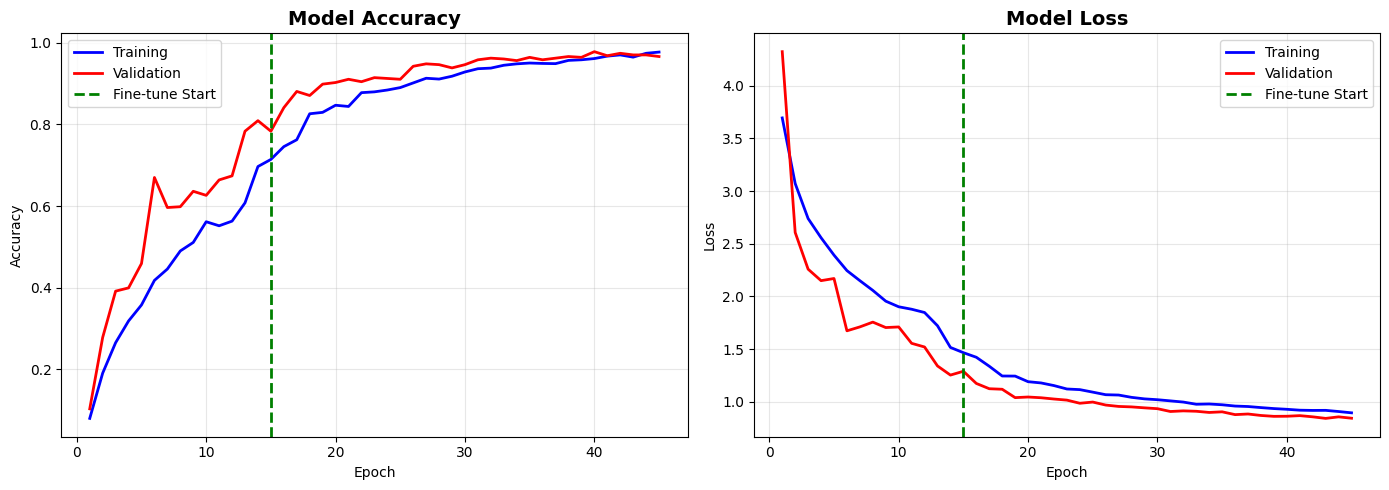

✅ Training curves saved!


In [13]:
# CELL 14: Plot Training Curves
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Combine histories
acc = history_warmup.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history_warmup.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history_warmup.history['loss'] + history_finetune.history['loss']
val_loss = history_warmup.history['val_loss'] + history_finetune.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Accuracy plot
axes[0].plot(epochs_range, acc, 'b-', label='Training', linewidth=2)
axes[0].plot(epochs_range, val_acc, 'r-', label='Validation', linewidth=2)
axes[0].axvline(x=EPOCHS_WARMUP, color='g', linestyle='--', label='Fine-tune Start', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Loss plot
axes[1].plot(epochs_range, loss, 'b-', label='Training', linewidth=2)
axes[1].plot(epochs_range, val_loss, 'r-', label='Validation', linewidth=2)
axes[1].axvline(x=EPOCHS_WARMUP, color='g', linestyle='--', label='Fine-tune Start', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_DIR, 'training_curves.png'), dpi=300)
plt.show()

print("✅ Training curves saved!")


In [14]:
# CELL 15: Final Evaluation
# ============================================================
print("\n" + "="*60)
print("📊 FINAL EVALUATION")
print("="*60)

eval_results = model.evaluate(val_ds, verbose=1)
print(f"\n✅ Validation Results:")
print(f"   Loss: {eval_results[0]:.4f}")
print(f"   Accuracy: {eval_results[1]:.4f}")
print(f"   Top-3 Accuracy: {eval_results[2]:.4f}")
print(f"   Top-5 Accuracy: {eval_results[3]:.4f}")


📊 FINAL EVALUATION
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9599 - loss: 0.8817 - top_3_acc: 1.0000 - top_5_acc: 1.0000

✅ Validation Results:
   Loss: 0.8632
   Accuracy: 0.9781
   Top-3 Accuracy: 1.0000
   Top-5 Accuracy: 1.0000


In [15]:
# ============================================================
def analyze_predictions(model, dataset, class_names, num_samples=100):
    """Comprehensive prediction analysis"""

    print("\n🔍 Analyzing predictions...")

    all_labels = []
    all_predictions = []
    all_probs = []

    # Collect predictions
    for images, labels in dataset.take(num_samples // BATCH_SIZE):
        predictions = model.predict(images, verbose=0)
        all_labels.extend(np.argmax(labels.numpy(), axis=1))
        all_predictions.extend(np.argmax(predictions, axis=1))
        all_probs.extend(predictions)

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    # Overall accuracy
    accuracy = np.mean(all_labels == all_predictions)
    print(f"\n📈 Sample Accuracy: {accuracy:.4f}")

    # Per-class accuracy
    print("\n📊 Per-Class Performance:")
    unique_labels = np.unique(all_labels)

    for label in unique_labels:
        mask = all_labels == label
        if mask.sum() > 0:
            class_acc = np.mean(all_predictions[mask] == label)
            print(f"   {class_names[label]:5s}: {class_acc:.4f} ({mask.sum()} samples)")

    # Most confused pairs
    print("\n⚠️ Most Confused Pairs:")
    confusion = []
    for i in range(len(all_labels)):
        if all_labels[i] != all_predictions[i]:
            confusion.append((
                class_names[all_labels[i]],
                class_names[all_predictions[i]]
            ))

    confusion_pairs = Counter(confusion)
    for (true_class, pred_class), count in confusion_pairs.most_common(5):
        print(f"   {true_class} → {pred_class}: {count} times")

    # Confidence analysis
    print("\n🎯 Prediction Confidence:")
    confidences = np.max(all_probs, axis=1)
    correct_mask = all_labels == all_predictions

    print(f"   Correct: {confidences[correct_mask].mean():.4f} ± {confidences[correct_mask].std():.4f}")
    if (~correct_mask).sum() > 0:
        print(f"   Incorrect: {confidences[~correct_mask].mean():.4f} ± {confidences[~correct_mask].std():.4f}")

    return all_labels, all_predictions, all_probs

# Run analysis
true_labels, pred_labels, pred_probs = analyze_predictions(model, val_ds, class_names)



🔍 Analyzing predictions...

📈 Sample Accuracy: 0.9271

📊 Per-Class Performance:
   0    : 1.0000 (2 samples)
   1    : 1.0000 (1 samples)
   2    : 1.0000 (4 samples)
   3    : 1.0000 (2 samples)
   4    : 1.0000 (2 samples)
   5    : 1.0000 (4 samples)
   6    : 1.0000 (2 samples)
   8    : 1.0000 (2 samples)
   9    : 1.0000 (2 samples)
   a    : 1.0000 (5 samples)
   b    : 1.0000 (3 samples)
   c    : 1.0000 (2 samples)
   d    : 1.0000 (1 samples)
   e    : 1.0000 (3 samples)
   f    : 1.0000 (2 samples)
   h    : 1.0000 (3 samples)
   i    : 1.0000 (4 samples)
   j    : 1.0000 (2 samples)
   k    : 1.0000 (3 samples)
   l    : 1.0000 (4 samples)
   n    : 0.6000 (5 samples)
   o    : 1.0000 (2 samples)
   p    : 1.0000 (7 samples)
   q    : 1.0000 (4 samples)
   s    : 1.0000 (3 samples)
   t    : 0.6667 (3 samples)
   u    : 1.0000 (3 samples)
   v    : 1.0000 (1 samples)
   w    : 0.6667 (6 samples)
   x    : 1.0000 (3 samples)
   y    : 1.0000 (3 samples)
   z    : 0.3333 (3 


📸 Generating prediction visualizations...


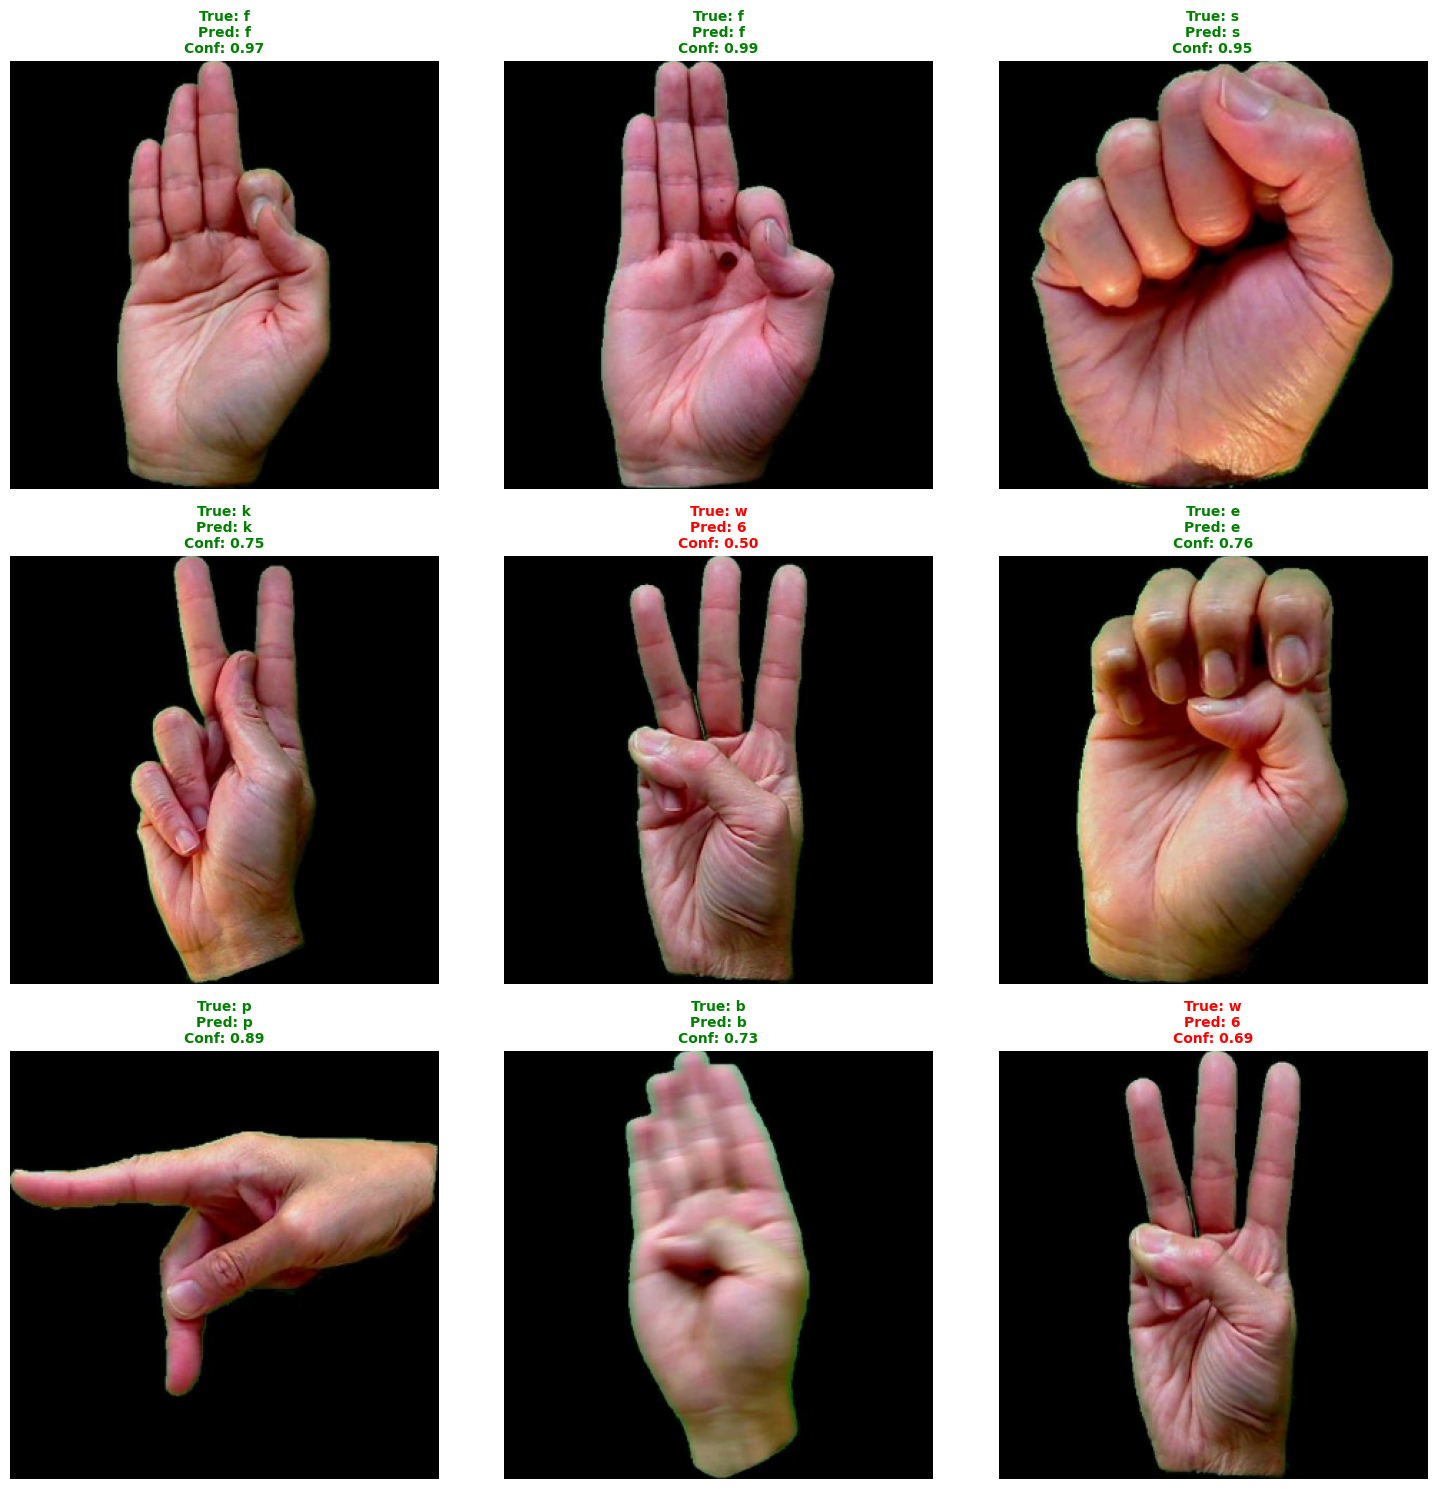

In [16]:
# ============================================================
def visualize_predictions(model, dataset, class_names, num_samples=9):
    """Visualize sample predictions"""

    plt.figure(figsize=(15, 15))

    images_shown = 0
    for images, labels in dataset.take(1):
        predictions = model.predict(images, verbose=0)

        for i in range(min(num_samples, len(images))):
            ax = plt.subplot(3, 3, images_shown + 1)

            # Display image (denormalize first)
            img = images[i].numpy()
            # EfficientNet preprocessing is more complex, so just scale to 0-255
            img = (img - img.min()) / (img.max() - img.min())
            img = (img * 255).astype(np.uint8)
            plt.imshow(img)

            # Get prediction details
            true_label = class_names[np.argmax(labels[i])]
            pred_label = class_names[np.argmax(predictions[i])]
            confidence = np.max(predictions[i])

            # Color code
            color = 'green' if true_label == pred_label else 'red'

            title = f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}"
            plt.title(title, fontsize=10, color=color, fontweight='bold')
            plt.axis('off')

            images_shown += 1
            if images_shown >= num_samples:
                break

        if images_shown >= num_samples:
            break

    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_SAVE_DIR, 'sample_predictions.png'), dpi=300)
    plt.show()

print("\n📸 Generating prediction visualizations...")
visualize_predictions(model, val_ds, class_names)

In [17]:
# ============================================================
print("\n💾 Saving models...")

# Save Keras model
model.save(FINAL_MODEL_PATH)
print(f"✅ Keras model saved: {FINAL_MODEL_PATH}")

# Convert to TFLite
print("Converting to TFLite...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(TFLITE_PATH, 'wb') as f:
    f.write(tflite_model)
print(f"✅ TFLite model saved: {TFLITE_PATH}")

# Model sizes
keras_size = os.path.getsize(FINAL_MODEL_PATH) / (1024**2)
tflite_size = os.path.getsize(TFLITE_PATH) / (1024**2)
print(f"\nModel sizes:")
print(f"   Keras: {keras_size:.1f} MB")
print(f"   TFLite: {tflite_size:.1f} MB")
print(f"   Compression: {(1 - tflite_size/keras_size)*100:.1f}%")


💾 Saving models...
✅ Keras model saved: /content/drive/MyDrive/sign_language_models/sign_language_final.keras
Converting to TFLite...
Saved artifact at '/tmp/tmpkiiw0m3u'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name='input')
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  137390372447888: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137390372448464: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137390465865808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137390465866960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137390465866000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137390465867728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137390465865616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137390465866384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1373904

In [18]:
from google.colab import files

download = input("\nDownload models to your computer? (y/n): ")

if download.lower() == 'y':
    print("Downloading...")
    files.download(FINAL_MODEL_PATH)
    files.download(TFLITE_PATH)
    print("✅ Models downloaded!")
else:
    print("Models are saved in Google Drive at:")
    print(f"   {MODEL_SAVE_DIR}")


Download models to your computer? (y/n): y
Downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Models downloaded!


In [19]:

# CELL 20: Training Summary
# ============================================================
print("\n" + "="*60)
print("🎉 TRAINING COMPLETE!")
print("="*60)
print(f"📊 Final Results:")
print(f"   Validation Accuracy: {eval_results[1]:.4f}")
print(f"   Top-3 Accuracy: {eval_results[2]:.4f}")
print(f"   Top-5 Accuracy: {eval_results[3]:.4f}")
print(f"\n⏱️ Training Time: {total_time/60:.1f} minutes")
print(f"💾 Models saved to: {MODEL_SAVE_DIR}")
print("\n✅ You can now use these models with the Streamlit app!")


🎉 TRAINING COMPLETE!
📊 Final Results:
   Validation Accuracy: 0.9781
   Top-3 Accuracy: 1.0000
   Top-5 Accuracy: 1.0000

⏱️ Training Time: 22.6 minutes
💾 Models saved to: /content/drive/MyDrive/sign_language_models

✅ You can now use these models with the Streamlit app!
